In [1]:
import keras
from keras.datasets import mnist
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import png
import cv2
import os

%matplotlib inline

Using TensorFlow backend.


In [2]:
def read_img(path, height=28, width=28):
    """
    function to read the MNIST images from disk
    data is load into a single numpy array of size (data_size, 28, 28)
    """
    height = 28
    width = 28
    list_dir = os.listdir(path)
    print("reading data from {}".format(path))
    data_size = len(list_dir)
    print("data size:", data_size)
    res = np.zeros((data_size, height, width))
    for i in range(data_size):
        img_path = path + "/" + str(i) + ".png"
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        res[i, :, :] = img
        if i%10000 == 9999:
            print("currently at line {}".format(i+1))
    return res
    
def read_label(path):
    """
    function to read the MNIST labels
    """
    return np.loadtxt(path, dtype=np.int16)

In [55]:
%%time
train_path = "data/MNIST/train"
test_path = "data/MNIST/test"
train_labels = "data/MNIST/train_labels.txt"
test_labels = "data/MNIST/test_labels.txt"

# read data
x_train = read_img(train_path)
x_test = read_img(test_path)
y_train = read_label(train_labels)
y_test = read_label(test_labels)

reading data from data/MNIST/train
data size: 60000
currently at line 10000
currently at line 20000
currently at line 30000
currently at line 40000
currently at line 50000
currently at line 60000
reading data from data/MNIST/test
data size: 10000
currently at line 10000
Wall time: 39.6 s


In [56]:
# print out shape of every data loaded
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((60000, 28, 28), (10000, 28, 28), (60000,), (10000,))

In [58]:
# number of images for each class
from collections import Counter
print(Counter(list(y_train)))
print(Counter(list(y_test)))

Counter({1: 6742, 7: 6265, 3: 6131, 2: 5958, 9: 5949, 0: 5923, 6: 5918, 8: 5851, 4: 5842, 5: 5421})
Counter({1: 1135, 2: 1032, 7: 1028, 3: 1010, 9: 1009, 4: 982, 0: 980, 8: 974, 6: 958, 5: 892})


(array([5923., 6742., 5958., 6131., 5842., 5421., 5918., 6265., 5851.,
        5949.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <a list of 10 Patch objects>)

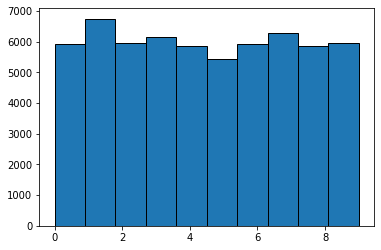

In [61]:
plt.hist(y_train, bins=10, ec="black")

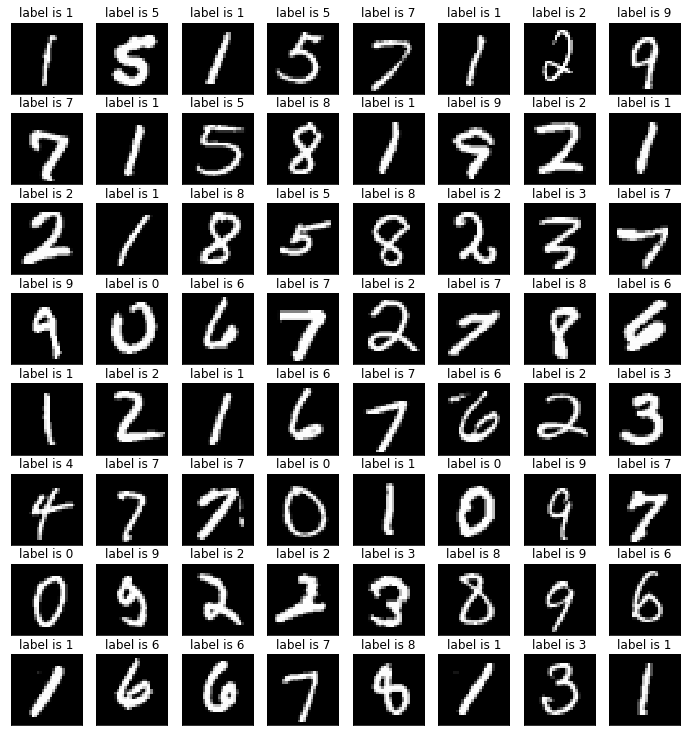

In [9]:
# showing sample of images
rd_idx = np.random.randint(0, 60000, 64)
sample = [x_train[i, :, :] for i in rd_idx]
sample_labels = [y_train[i] for i in rd_idx]
plt.figure(figsize=(12, 13))
ix = 1
for _ in range(8):
    for _ in range(8):
        # specify subplot and turn of axis
        ax = plt.subplot(8, 8, ix)
        ax.set_xticks([])
        ax.set_yticks([])
        # plot filter channel in grayscale
        plt.imshow(sample[ix-1].reshape(28, 28), cmap='gray')
        ax.set_title("label is {}".format(sample_labels[ix-1]))
        ix += 1
# show the figure
plt.show()

In [64]:
# define batch size, number of classes and number of epochs
batch_size = 128
num_classes = 10
epochs = 5

# preprocessing data
# rescale image to range [0, 1]
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, 10)
y_test = keras.utils.to_categorical(y_test, 10)

x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)
input_shape = (img_rows, img_cols, 1)

In [65]:
# CREATE MODEL IN KERAS
model = Sequential()

model.add(Conv2D(filters=32, 
                 kernel_size=(3, 3),
                 activation='relu',
                 padding="same", 
                 input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=64,                  
                 kernel_size=(3, 3), 
                 activation='relu', 
                 padding="same"))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

# DEFINE LOSS FUNCTION AND OPTIMIZER
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])

print(model.summary())

model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test))
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 14, 14, 64)        18496     
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 7, 7, 64)          0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 3136)              0         
_________________________________________________________________
dense_11 (Dense)             (None, 512)               1606144   
_________________________________________________________________
dense_12 (Dense)             (None, 10)               

In [45]:
#save the model into disk
model.save("models/CNN_Keras/model.h5")

In [48]:
# # load the model from disk
# from keras.models import load_model
# model = load_model("models/CNN_Keras/model.h5")

In [17]:
# get the trained weights of the model
weights = model.get_weights()
# print out shape of weights for each layers
for i, w in enumerate(weights):
    print("layer {} has shape {}".format(i, w.shape))

layer 0 has shape (3, 3, 1, 32)
layer 1 has shape (32,)
layer 2 has shape (3, 3, 32, 64)
layer 3 has shape (64,)
layer 4 has shape (3136, 512)
layer 5 has shape (512,)
layer 6 has shape (512, 10)
layer 7 has shape (10,)


In [18]:
# plot all 64 maps in an 8x8 squares
def plot_feature_map(layer, filters):
    #create a new model with input and output from the trained model
    feat_model = Model(inputs=model.inputs, outputs=model.layers[layer].output)
    
    # get the output of model
    feature_maps = feat_model.predict(x_train[i, :, :].reshape(1, 28, 28, 1))
    print("layer {} has shape: {}".format(layer, feature_maps.shape))
    square = 8
    rows = int(filters/square)
    ix = 1
    
    # plot the feature map
    plt.figure(figsize=(square, rows))
    for _ in range(rows):
        for _ in range(square):
            # specify subplot and turn of axis
            ax = plt.subplot(rows, square, ix)
            ax.set_xticks([])
            ax.set_yticks([])
            # plot filter channel in grayscale
            plt.imshow(feature_maps[0, :, :, ix-1], cmap='gray')
            ix += 1
    # show the figure
    plt.show()

layer 0 has shape: (1, 28, 28, 32)


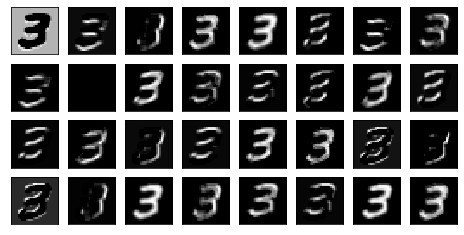

layer 1 has shape: (1, 14, 14, 32)


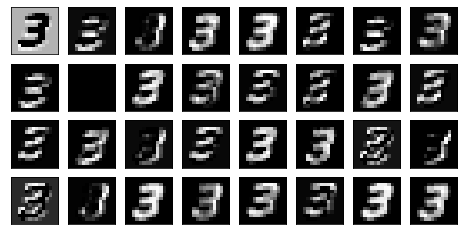

layer 2 has shape: (1, 14, 14, 64)


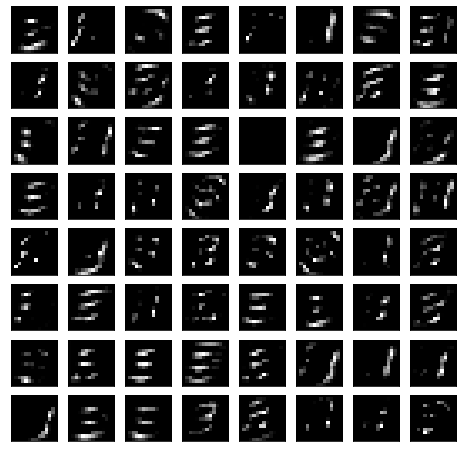

layer 3 has shape: (1, 7, 7, 64)


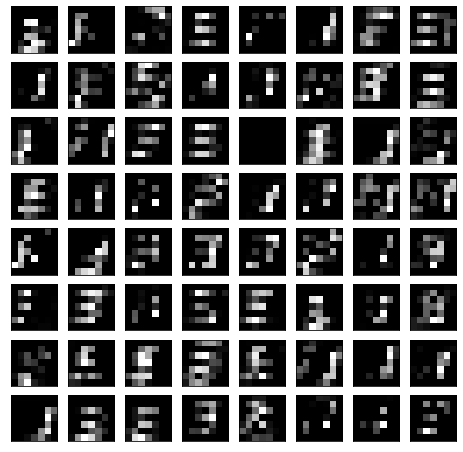

In [19]:
plot_feature_map(0, 32)
plot_feature_map(1, 32)
plot_feature_map(2, 64)
plot_feature_map(3, 64)

In [32]:
def predict_image(path):
    """
    function to predict from an image on disk
    """
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (28, 28))
    plt.imshow(img, cmap="gray")
    plt.show()
    output = model.predict(img.reshape(1, 28, 28, 1))
    pred = np.argmax(output, axis=1)[0]
    return pred

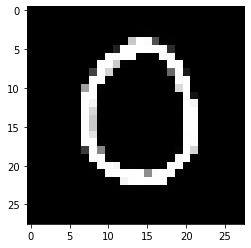

Predicted as 0


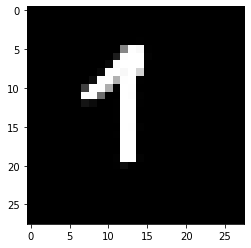

Predicted as 1


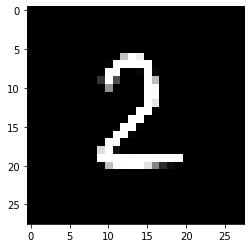

Predicted as 2


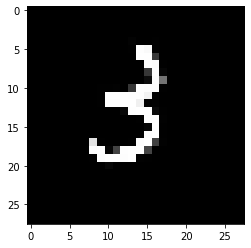

Predicted as 3


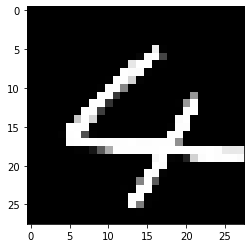

Predicted as 4


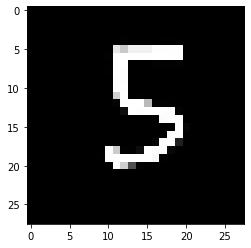

Predicted as 5


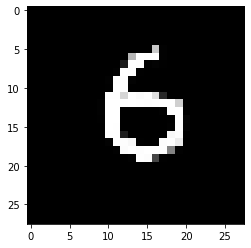

Predicted as 6


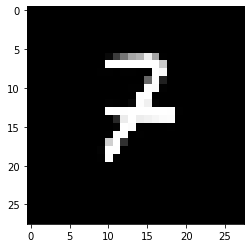

Predicted as 7


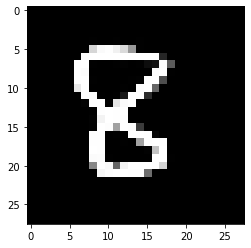

Predicted as 8


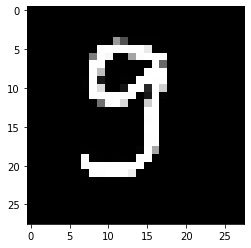

Predicted as 3


In [42]:
for i in range(10):
    path = "test_paint/" + str(i) + ".jpeg"
    prediction = predict_image(path)
    print("Predicted as", prediction)
    print("=================================")